In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/results-moda/risk_predictions_full.csv


In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/results-moda/risk_predictions_full.csv")
df.head()


,region_id,risk_level,risk_name,confidence_low,confidence_medium,confidence_high,max_confidence,avg_sst,vegetation_index,distance_to_urban
0,SUND_1,2,High,0.000473,0.028176,0.971351,0.971351,26.996321,0.140395,9.654458
1,SUND_2,2,High,0.000188,0.021255,0.978556,0.978556,30.929409,0.749198,32.638527
2,SUND_3,0,Low,0.982723,0.017253,0.000024,0.982723,25.454600,0.262106,92.166081
3,SUND_4,1,Medium,0.026888,0.971260,0.001852,0.971260,25.115951,0.179706,77.620931
4,SUND_5,0,Low,0.526893,0.472119,0.000988,0.526893,28.739317,0.853997,144.879173


In [3]:
df.shape
df.columns
df.describe()

,risk_level,confidence_low,confidence_medium,confidence_high,max_confidence,avg_sst,vegetation_index,distance_to_urban
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.971000,0.182923,0.664656,0.152420,0.960407,28.037976,0.432928,74.892613
std,0.573138,0.362746,0.436505,0.338314,0.073639,2.320742,0.252850,42.997083
min,0.000000,0.000004,0.000237,0.000002,0.503916,24.000246,0.001218,1.165702
25%,1.000000,0.001135,0.053811,0.000901,0.963003,26.069879,0.217464,37.721675
50%,1.000000,0.004001,0.973877,0.003143,0.983938,28.023261,0.426327,73.399692
75%,1.000000,0.033631,0.990558,0.016725,0.992863,30.044050,0.642138,113.180595
max,2.000000,0.999760,0.998660,0.999745,0.999760,31.991141,0.899515,149.957933


In [4]:
import numpy as np
np.random.seed(42)

df["carbon_potential"] = (
    0.6 * df["vegetation_index"] +
    np.random.uniform(0.2, 0.5, len(df))
)

df["biodiversity_score"] = (
    0.5 * df["vegetation_index"] +
    np.random.uniform(0.3, 0.6, len(df))
)

df["restoration_cost"] = (
    1 / (df["distance_to_urban"] + 1) +
    np.random.uniform(0.1, 0.3, len(df))
)

df["ngo_readiness"] = np.random.uniform(0.5, 1.0, len(df))


In [5]:
df["priority_score"] = (
    0.45 * df["risk_level"] +
    0.25 * df["carbon_potential"] +
    0.2 * df["biodiversity_score"] +
    0.1 * df["ngo_readiness"] -
    0.05 * df["restoration_cost"]
)

In [6]:
X = df.drop(["region_id", "risk_name", "priority_score"], axis=1)
y = df["priority_score"]


In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

rmse = mean_squared_error(y_test, preds) ** 0.5

print("RMSE:", rmse)

RMSE: 0.011246107878721755


In [8]:
df["predicted_priority"] = model.predict(X)

In [9]:
df["predicted_priority"] = model.predict(X)

priority_sites = df.sort_values(
    "predicted_priority", ascending=False
)

priority_sites[["region_id", "predicted_priority"]].head(10)


,region_id,predicted_priority
1,SUND_2,1.378250
146,SUND_147,1.376253
795,GBR_296,1.365410
646,GBR_147,1.327434
651,GBR_152,1.323771
486,SUND_487,1.307981
974,GBR_475,1.298376
751,GBR_252,1.297728
43,SUND_44,1.293030
496,SUND_497,1.292127


In [10]:
priority_sites.to_csv("priority_sites.csv", index=False)

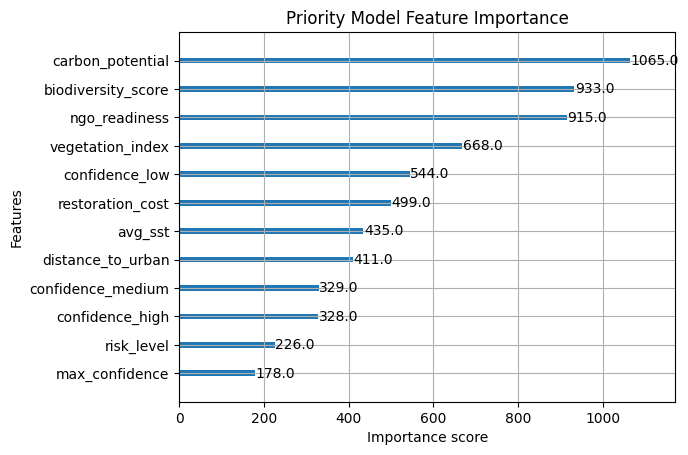

In [11]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model)
plt.title("Priority Model Feature Importance")
plt.show()

In [12]:
df["priority_score_scaled"] = (
    (df["predicted_priority"] - df["predicted_priority"].min()) /
    (df["predicted_priority"].max() - df["predicted_priority"].min())
) * 100

In [13]:
priority_sites[[
    "region_id",
    "risk_level",
    "carbon_potential",
    "biodiversity_score",
    "restoration_cost",
    "ngo_readiness",
    "predicted_priority"
]].head(20)

,region_id,risk_level,carbon_potential,biodiversity_score,restoration_cost,ngo_readiness,predicted_priority
1,SUND_2,2,0.934733,0.837169,0.179124,0.898341,1.378250
146,SUND_147,2,0.838926,0.919275,0.212036,0.947673,1.376253
795,GBR_296,2,0.988462,0.764458,0.303991,0.829359,1.365410
646,GBR_147,2,0.871120,0.749183,0.302822,0.743633,1.327434
651,GBR_152,2,0.836198,0.786827,0.280878,0.698933,1.323771
486,SUND_487,2,0.752353,0.867785,0.223009,0.677462,1.307981
974,GBR_475,2,0.730871,0.824214,0.206218,0.635746,1.298376
751,GBR_252,2,0.783102,0.615520,0.333475,0.954588,1.297728
43,SUND_44,2,0.751598,0.720103,0.142906,0.701801,1.293030
496,SUND_497,2,0.664502,0.727018,0.228827,0.931498,1.292127


In [14]:
priority_sites.tail(20)


,region_id,risk_level,risk_name,confidence_low,confidence_medium,confidence_high,max_confidence,avg_sst,vegetation_index,distance_to_urban,carbon_potential,biodiversity_score,restoration_cost,ngo_readiness,priority_score,predicted_priority
624,GBR_125,0,Low,0.999716,0.000280,0.000004,0.999716,25.306934,0.358014,77.244410,0.600285,0.531598,0.188244,0.624834,0.309462,0.310505
562,GBR_63,0,Low,0.866294,0.133491,0.000215,0.866294,26.457731,0.376330,113.835164,0.466710,0.722323,0.118753,0.528489,0.308053,0.308663
8,SUND_9,0,Low,0.991892,0.008089,0.000018,0.991892,24.707940,0.244214,124.481889,0.526863,0.497007,0.121043,0.837010,0.308766,0.307251
225,SUND_226,0,Low,0.944860,0.054960,0.000181,0.944860,24.765716,0.208752,59.244993,0.398448,0.595934,0.210352,0.945428,0.302824,0.303487
817,GBR_318,0,Low,0.977076,0.022688,0.000236,0.977076,25.150944,0.117288,96.870913,0.390074,0.589411,0.112638,0.911776,0.300946,0.301221
950,GBR_451,0,Low,0.944768,0.055119,0.000113,0.944768,24.710186,0.376172,38.427609,0.605858,0.514666,0.290864,0.511854,0.291040,0.293146
973,GBR_474,0,Low,0.848768,0.150048,0.001185,0.848768,24.416579,0.212009,139.943089,0.391688,0.561428,0.253984,0.854719,0.282980,0.292950
430,SUND_431,0,Low,0.890507,0.109173,0.000320,0.890507,28.390869,0.300645,110.172159,0.423284,0.586744,0.229584,0.790475,0.290738,0.290942
925,GBR_426,0,Low,0.935475,0.063426,0.001099,0.935475,31.397269,0.533244,72.891466,0.526687,0.594519,0.293921,0.512885,0.287168,0.287848
434,SUND_435,0,Low,0.988573,0.011372,0.000055,0.988573,24.540020,0.363241,110.944863,0.443177,0.523516,0.301160,0.853699,0.285809,0.287084


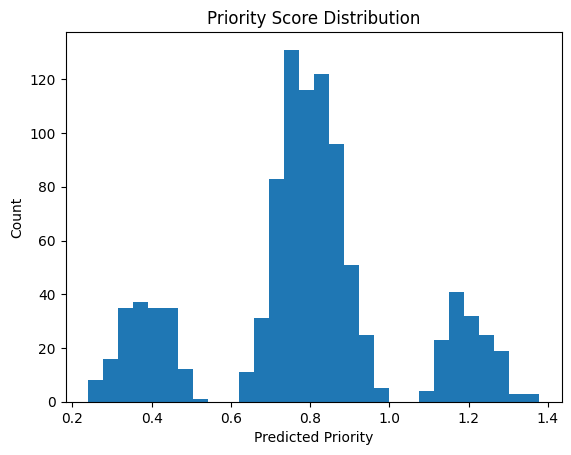

In [15]:
import matplotlib.pyplot as plt

plt.hist(df["predicted_priority"], bins=30)
plt.title("Priority Score Distribution")
plt.xlabel("Predicted Priority")
plt.ylabel("Count")
plt.show()

In [16]:
df.groupby("risk_level")["predicted_priority"].mean()

risk_level
0    0.385233
1    0.798787
2    1.204159
Name: predicted_priority, dtype: float32

In [17]:
df.sort_values("predicted_priority", ascending=False)[
    ["risk_level", "predicted_priority"]
].head(20)

,risk_level,predicted_priority
1,2,1.378250
146,2,1.376253
795,2,1.365410
646,2,1.327434
651,2,1.323771
486,2,1.307981
974,2,1.298376
751,2,1.297728
43,2,1.293030
496,2,1.292127


In [18]:
df.sort_values("predicted_priority")[
    ["risk_level", "predicted_priority"]
].head(20)

,risk_level,predicted_priority
99,0,0.239894
122,0,0.240705
699,0,0.249985
753,0,0.266302
95,0,0.267609
505,0,0.269050
65,0,0.270939
278,0,0.276691
595,0,0.278016
727,0,0.286535


V2 (just adding interaction features)
and
changing 0.45 * risk_level to 0.30 * risk_level

so that 
-carbon potential matter more
-biodiversity matter more
-rankings look less clustered

Hybrid prioritization
Risk + Impact + Feasibility


We built a multi-factor restoration prioritization model that balances ecological risk, carbon sequestration potential, biodiversity value, and restoration feasibility using gradient-boosted regression.

1) improved restoration features

In [19]:
import numpy as np
np.random.seed(42)

df["carbon_potential"] = (
    0.6 * df["vegetation_index"] +
    np.random.uniform(0.2, 0.5, len(df))
)

df["biodiversity_score"] = (
    0.5 * df["vegetation_index"] +
    np.random.uniform(0.3, 0.6, len(df))
)

df["restoration_cost"] = (
    1 / (df["distance_to_urban"] + 1) +
    np.random.uniform(0.1, 0.3, len(df))
)

df["ngo_readiness"] = np.random.uniform(0.5, 1.0, len(df))


2) interaction features

In [20]:
df["impact_potential"] = (
    df["carbon_potential"] * df["biodiversity_score"]
)

df["feasibility"] = (
    df["ngo_readiness"] / (df["restoration_cost"] + 0.1)
)

3) Improved priority scoring

In [21]:
df["priority_score"] = (
    0.30 * df["risk_level"] +
    0.30 * df["carbon_potential"] +
    0.25 * df["biodiversity_score"] +
    0.10 * df["ngo_readiness"] -
    0.05 * df["restoration_cost"]
)

4. Prepare training data

In [22]:
X = df.drop([
    "region_id",
    "risk_name",
    "priority_score",
    "predicted_priority",
    "priority_score_scaled"
], axis=1, errors="ignore")

y = df["priority_score"]



5. Train/test split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

6. Hyperparameter tuning

In [24]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "max_depth": [4,5,6,7],
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [150,200,300],
    "subsample": [0.7, 0.8, 1.0]
}

search = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_grid,
    n_iter=8,
    cv=3,
    verbose=1
)

search.fit(X_train, y_train)

model = search.best_estimator_
print("Best parameters:", search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05}


7) Evaluate model

In [25]:
from sklearn.metrics import mean_squared_error

preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 0.5
print("RMSE:", rmse)

RMSE: 0.006370989514107447


8) Feature importance

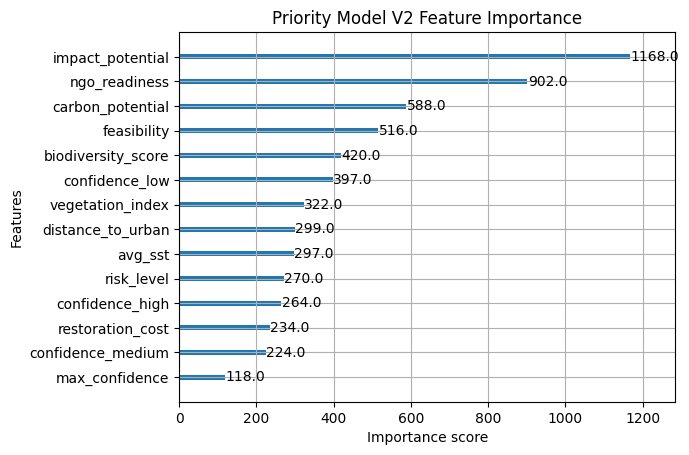

In [26]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model)
plt.title("Priority Model V2 Feature Importance")
plt.show()

9. Generate ranked restoration sites

In [27]:
df["predicted_priority"] = model.predict(X)

priority_sites = df.sort_values(
    "predicted_priority",
    ascending=False
)

Scale scores (UI-ready)

In [28]:
df["priority_score_scaled"] = (
    (df["predicted_priority"] - df["predicted_priority"].min()) /
    (df["predicted_priority"].max() - df["predicted_priority"].min())
) * 100

Export

In [29]:
priority_sites.to_csv("priority_sites_v2.csv", index=False)